In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = "/media/aspa2/KINGSTON/SummerResearch/MMXXII"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


# WEIGHTS_PATH = "/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220119T0918/mask_rcnn_object_0037.h5"   # non_occluded
# WEIGHTS_PATH = "/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220118T1319/mask_rcnn_object_0090.h5"   # occluded
# WEIGHTS_PATH = "/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220120T1046/mask_rcnn_object_0500.h5"   # occluded_0120
# WEIGHTS_PATH = "/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220120T1508/archives/mask_rcnn_object_0022.h5"   # occluded_0120
# WEIGHTS_PATH = "/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220120T1624/archives/mask_rcnn_object_0010.h5"   # occluded_0120
# WEIGHTS_PATH = "/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220121T0847/archives/mask_rcnn_object_0010.h5"   # occluded_0121
# WEIGHTS_PATH = "/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220121T0956/mask_rcnn_object_0038.h5"   # occluded_0121
# WEIGHTS_PATH = "/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220121T1247/mask_rcnn_object_0100.h5"   # occluded_0121
# WEIGHTS_PATH = "/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220121T1435/archives/mask_rcnn_object_0500.h5"   # occluded_0122
WEIGHTS_PATH = "/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220122T1721/archives/mask_rcnn_object_3000.h5"   # occluded_0124

Using TensorFlow backend.


In [2]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # Background + rockmelon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [3]:
# Code for Customdataset class. Same code is present in custom.py file also
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "rockmelon")

        # Train or validation dataset?
        #assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, "train")

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(r'/home/aspa2/rockmelon/MMXXII/Dataset/train/train_json.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"rockmelon": 1}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [4]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = r"/home/aspa2/rockmelon/MMXXII/Dataset"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = r"/home/aspa2/rockmelon/MMXXII/Dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1]
objects: ['rockmelon', 'rockmelon']
numids [1, 1]
objects: ['rockmelon', 'rockmelon']
numids [1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon']
numids [1, 1]
objects: ['rockmelon']
numids [1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1]
objects: ['rockmelon']
numids [1]
objects: ['rockmelon', 'rockmelon', 'rockmelon

objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1, 1]
objects: ['rockmelon']
numids [1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1]
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmel

In [5]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [6]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220122T1721/archives/mask_rcnn_object_3000.h5


2022-01-24 11:22:20.563687: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-01-24 11:22:20.568571: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3503900000 Hz
2022-01-24 11:22:20.568780: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xece9770 executing computations on platform Host. Devices:
2022-01-24 11:22:20.568808: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-01-24 11:22:20.570762: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2022-01-24 11:22:20.649588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 11:22:20.650441: I tensorflow/compiler/xla/service/servi

Processing 1 images
image                    shape: (480, 640, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


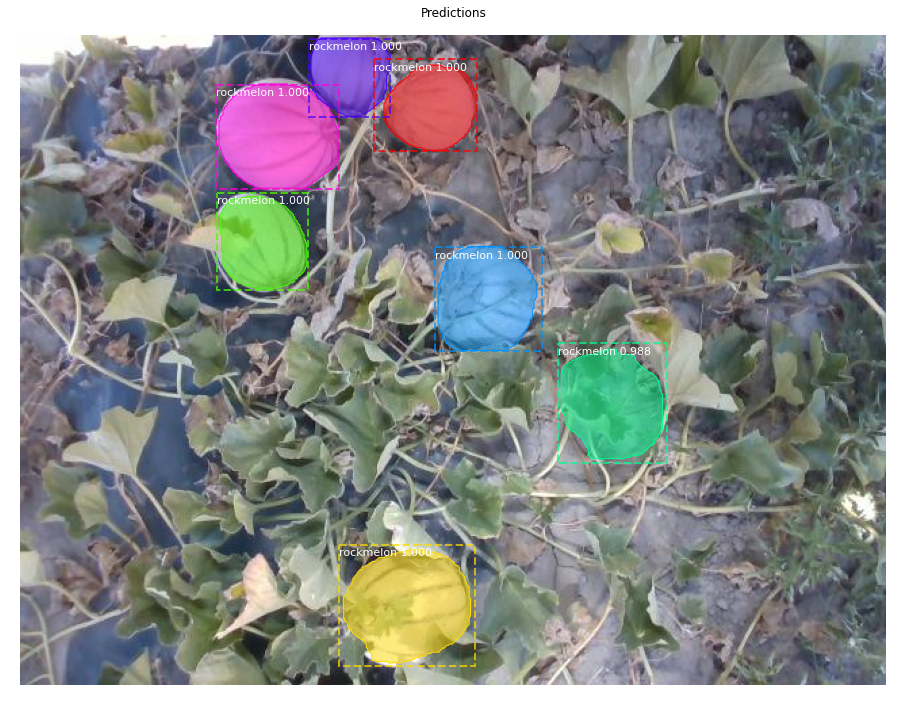

In [22]:
# This is for predicting images which are not present in dataset
path_to_new_image = r'/home/aspa2/rockmelon/MMXXII/Dataset/test/rgb_image30.jpg'
image1 = mpimg.imread(path_to_new_image)

# Run object detection
#print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions")

In [7]:
# Loop through and predict all the images in a directory

StartTime = time.time()

directory = r"/home/aspa2/rockmelon/MMXXII/Dataset/test/"

num_files = len(os.listdir(directory))-1

for i in range(num_files):
    filename = "rgb_image%s.jpg" %(i+1)
    print(filename)
    path_to_new_image = os.path.join(directory, filename)
    image = mpimg.imread(path_to_new_image)

    '''# Show original
    imgplot = plt.imshow(image)
    plt.show()'''

    # Run object detection
    results1 = model.detect([image], verbose=1)

    # Display results
    ax = get_ax(1)
    r1 = results1[0]
    visualize.display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
    dataset.class_names, r1['scores'], ax=ax, title=filename, save_image=True, save_dir="3000", save_filename=filename)

StopTime = time.time()

num_min = (StopTime-StartTime)/60
num_sec = (StopTime-StartTime)%60

print("Total Execution Time: %d minutes %d seconds" %(num_min, num_sec))

rgb_image1.jpg
Processing 1 images
image                    shape: (480, 640, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


2022-01-24 11:22:30.633107: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
2022-01-24 11:22:30.729358: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcublas.so.10.0
2022-01-24 11:22:30.899798: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudnn.so.7


rgb_image2.jpg
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
rgb_image3.jpg
Processing 1 images
image                    shape: (480, 640, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
rgb_image4.jpg
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1

rgb_image22.jpg
Processing 1 images
image                    shape: (480, 640, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
rgb_image23.jpg
Processing 1 images
image                    shape: (480, 640, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
rgb_image24.jpg
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1

In [13]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

from sklearn import metrics
from mrcnn.model import *
from mrcnn.utils import *

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        num_instances = 0
        
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "rockmelon")

        # Train or validation dataset?
        #assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, "test")

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(r'/home/aspa2/rockmelon/MMXXII/Dataset/test/test_json.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            print(a['filename'])
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"rockmelon": 1}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            instances = len(num_ids)
            num_instances += instances
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )
            
        return num_instances

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
            

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # Background + rockmelon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
            

def evaluate_model(dataset, model, cfg, list_iou_thresholds=None):
    if list_iou_thresholds is None: list_iou_thresholds = np.arange(0.5, 1.01, 0.1)

    APs = []
    ARs = []
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        #scaled_image = mold_image(image, cfg)
        scaled_image = image
        sample = np.expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=0.5)
        AR = compute_ar(r['rois'], gt_bbox, list_iou_thresholds)
        ARs.append(AR)
        APs.append(AP)

    mAP = np.mean(APs)
    mAR = np.mean(ARs)
    f1_score = 2 * ((mAP * mAR) / (mAP + mAR))

    return mAP, mAR, f1_score


def compute_ar(pred_boxes, gt_boxes, list_iou_thresholds):
    AR = []
    for iou_threshold in list_iou_thresholds:
        try:
            recall, _ = compute_recall(pred_boxes, gt_boxes, iou=iou_threshold)
            AR.append(recall)
        except:
            AR.append(0.0)
            pass

    AUC = 2 * (metrics.auc(list_iou_thresholds, AR))
    return AUC

CUSTOM_DIR = "/home/aspa2/rockmelon/MMXXII/Dataset/"
test_set = CustomDataset()
num_instances = test_set.load_custom(CUSTOM_DIR, "test")
test_set.prepare()

cfg = CustomConfig()
model = MaskRCNN(mode='inference', model_dir="/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/", config=cfg)
model.load_weights("/media/aspa2/KINGSTON/SummerResearch/MMXXII/logs/object20220122T1721/archives/mask_rcnn_object_3000.h5", by_name=True)
mAP, mAR, F1_score = evaluate_model(test_set, model, cfg)
print("Number of Instances: ", num_instances)
print("Mean Average Precision (mAP): %.3f" % mAP)
print("Mean Average Recall (mAR): %.3f" % mAR)
print("F1-Score: %.3f" % F1_score)

rgb_image1.jpg
objects: ['rockmelon']
numids [1]
rgb_image2.jpg
objects: ['rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1]
rgb_image3.jpg
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1]
rgb_image4.jpg
objects: ['rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1]
rgb_image5.jpg
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1, 1]
rgb_image6.jpg
objects: ['rockmelon', 'rockmelon']
numids [1, 1]
rgb_image8.jpg
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1]
rgb_image9.jpg
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon']
numids [1, 1, 1, 1, 1, 1, 1]
rgb_image10.jpg
objects: ['rockmelon', 'rockmelon']
numids [1, 1]
rgb_image11.jpg
objects: ['rockmelon']
numids [1]
rgb_image12.jpg
objects: ['rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', 'rockmelon', '

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
#
# Load the dataset
#
CUSTOM_DIR = r"/home/aspa2/rockmelon/MMXXII/Dataset"
ds = CustomDataset()
ds.load_custom(CUSTOM_DIR, "val")
X = ds.data
y = ds.target

image id is : 5
image ID: object.rgb_image6.jpg (5) /home/aspa2/rockmelon/MMXXII/Dataset/test/rgb_image6.jpg
(1024, 1024, 3)
{'id': 'rgb_image6.jpg', 'source': 'object', 'path': '/home/aspa2/rockmelon/MMXXII/Dataset/test/rgb_image6.jpg', 'width': 640, 'height': 480, 'polygons': [{'name': 'polygon', 'all_points_x': [1, 19, 36, 30, 14, 2], 'all_points_y': [122, 131, 160, 188, 205, 211]}, {'name': 'polygon', 'all_points_x': [88, 80, 85, 107, 126, 150, 152, 148, 144], 'all_points_y': [1, 19, 44, 67, 66, 51, 25, 5, 0]}], 'num_ids': [1, 1]}
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min: 

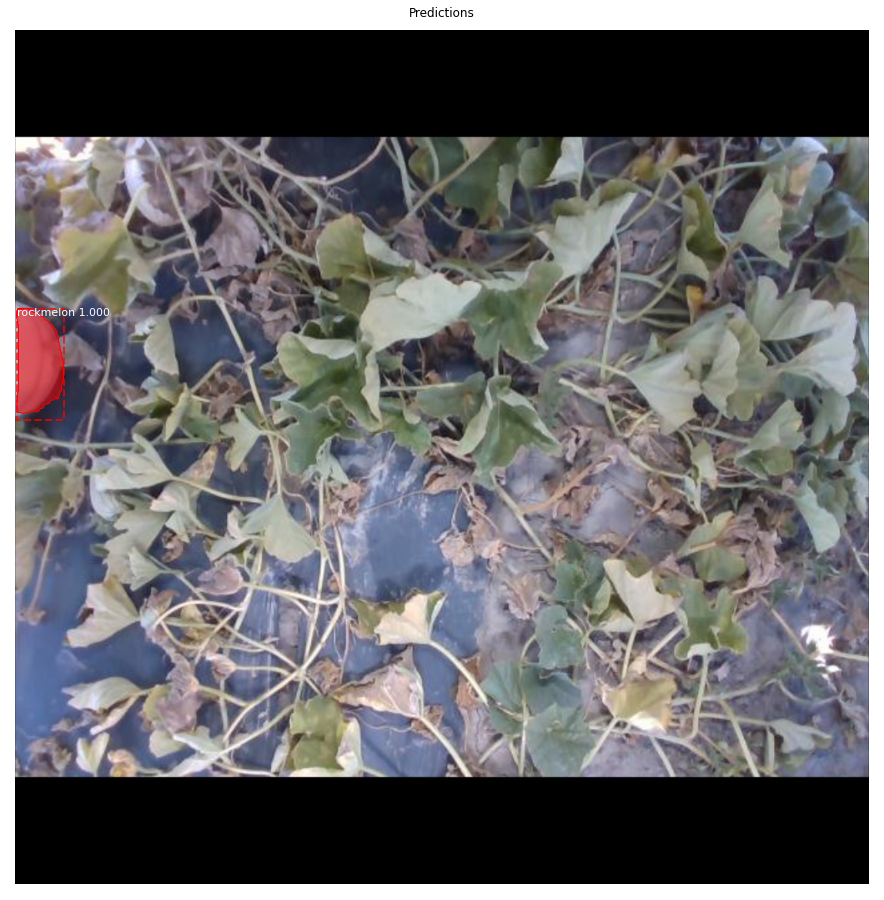

In [23]:
#RUN DETECTION
#image_id = random.choice(dataset.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
image_id = 5
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))
print(np.shape(image))
print(info)

# Run object detection
results = model.detect([image], verbose=1)

x = get_ax(1)
r = results[0]
ax = plt.gca()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [17]:
dataset = test_set
config = CustomConfig()

In [18]:
import mrcnn.utils as utils
import numpy as np


total_gt = np.array([]) 
total_pred = np.array([]) 
mAP_ = [] #mAP list

#compute total_gt, total_pred and mAP for each image in the test dataset
# Compute total ground truth boxes(total_gt) and total predicted boxes(total_pred) and mean average precision for each Image 
#in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset, config, image_id)#, #use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    total_gt = np.append(total_gt, gt)
    total_pred = np.append(total_pred, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual length of the ground truth vect is : ", len(total_gt))
    print("the actual length of the predicted vect is : ", len(total_pred))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))

import pandas as pd
total_gt=total_gt.astype(int)
total_pred=total_pred.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"Total Groundtruth" : total_gt, "predicted box" : total_pred}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual length of the ground truth vect is :  1
the actual length of the predicted vect is :  1
Average precision of this image :  1.0
The actual mean average precision for the whole images 1.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the

the actual length of the ground truth vect is :  67
the actual length of the predicted vect is :  67
Average precision of this image :  0.8571428656578064
The actual mean average precision for the whole images 0.8842403664475397
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual length of the ground truth vect is :  74
the actual length of the predicted vect is :  74
Average precision of this image :  1.0
The actual mean average precision for the whole images 0.891957675351037
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 10

the actual length of the ground truth vect is :  121
the actual length of the predicted vect is :  121
Average precision of this image :  1.0
The actual mean average precision for the whole images 0.9022392316233544
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual length of the ground truth vect is :  128
the actual length of the predicted vect is :  128
Average precision of this image :  1.0
The actual mean average precision for the whole images 0.9056102926018594
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    